# Implementing CNN Functions From Scratch

 * Convolution Function: Develop forward and backward passes, encompassing windowing and zero-padding with parameters [3,3,3,3] <br>
 * Pooling Functions: Design a pooling process involving mask creation, value distribution, and both forward and backward pooling with [2,3,3,2]

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# %cd /content/gdrive/MyDrive

## Convolution Functions

In [111]:
# image is a 4D numpy array which represents batch, image_height, image_width, channels respectively
# kernel is also a 4D numpy array which represents (height, width, input_channels, output_channels)

def window(image, b, i, j, kh, kw):
    new_height = i + kh
    new_width = j + kw
    return image[b, i : new_height, j : new_width, :]


def zero_padding(X, pad):
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad


def convolution_forward(image, kernel):
    batch_size, input_height, input_width, input_channels = image.shape
    kernel_height, kernel_width, _, output_channels = kernel.shape

    # iterates over each position of the image using for loops and convolves it
    result = np.zeros((batch_size, input_height - kernel_height + 1, input_width - kernel_width + 1, output_channels))
    for b in range(batch_size):
        for i in range(input_height - kernel_height + 1):
            for j in range(input_width - kernel_width + 1):
                for k in range(output_channels):
                    # calculating the image window
                    image_window = window(image, b, i, j, kernel_height, kernel_width)
                    result[b, i, j, k] = np.sum(image_window * kernel[:, :, :, k])

    return result


def convolution_backward(doutput, image, kernel):
    batch_size, input_height, input_width, input_channels = image.shape
    kernel_height, kernel_width, _, output_channels = kernel.shape

    # dimage is the gradient of the loss with respect to the input image
    dimage = np.zeros_like(image)
    dkernel = np.zeros_like(kernel)

    # iterating over each pixel position
    for b in range(batch_size):
        for i in range(input_height - kernel_height + 1):
            for j in range(input_width - kernel_width + 1):
                for k in range(output_channels):
                    dimage[b, i:i+kernel_height, j:j+kernel_width, :] += doutput[b, i, j, k] * kernel[:, :, :, k]
                    dkernel[:, :, :, k] += doutput[b, i, j, k] * window(image, b, i, j, kernel_height, kernel_width)

    return dimage, dkernel

## Pooling Functions

In [75]:
def pool_forward(A_prev, hparameters, mode = "max"):
    # Implements the forward pass of the pooling layer
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    A = np.zeros((m, n_H, n_W, n_C))
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range (n_C):
                    vert_start = h * stride
                    vert_end = vert_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end,c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    cache = (A_prev, hparameters)
    return A, cache

def create_mask_from_window(x):
    # Creates a mask from an input matrix x, to identify the max entry of x.
    mask = x == np.max(x)
    return mask

def distribute_value(dz, shape):
    # Distributes the input value in the matrix of dimension shape
    (n_H, n_W) = shape
    average = dz / (n_H * n_W)
    a = np.ones(shape) * average
    return a

def pool_backward(dA, cache, mode = "max"):
    # Implements the backward pass of the pooling layer
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    dA_prev = np.zeros(A_prev.shape)
    for i in range(m):
        a_prev = A_prev[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i, h, w, c])
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += distribute_value(da, shape)
    return dA_prev

## Testing the functions

In [114]:
def plot_figures(fig_dict, fig_size=(10, 15)):
    # the figure will be a dictionary consisting of the title and the image
    fig, axarr = plt.subplots(1, len(fig_dict), figsize=fig_size)
    i = 0
    for title, image in fig_dict.items():
        axarr[i].set_title(title)
        axarr[i].imshow(image)
        i += 1
    plt.tight_layout()
    plt.show()

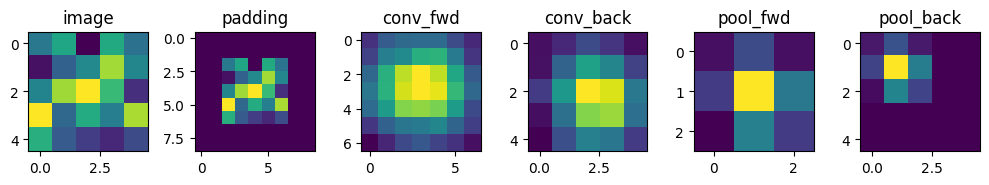

In [115]:
# np.random.seed(1)
image = np.random.rand(2, 5, 5, 3)  # Batch of 2 images with size 5x5 and 3 channels
kernel = np.random.rand(3, 3, 3, 3)  # Convolution kernel with size 3x3 and 3 input/output channels
image_padded = zero_padding(image, 2)

# Convolution forward pass
conv_result = convolution_forward(image_padded, kernel)

# # Convolution backward pass
doutput = np.random.rand(*conv_result.shape)  # Gradient of the loss with respect to the output of the convolution layer
dimage, dkernel = convolution_backward(doutput, image, kernel)

# Max pooling forward pass
pool_result, mask = pool_forward(dimage, {"stride" : 2, "f": 1})

# Max pooling backward pass
pool_result_back = pool_backward(pool_result, mask)

fig_dict = {'image': image[0,:,:,0],
            'padding': image_padded[0,:,:,0],
            'conv_fwd': conv_result[0,:,:,0],
            'conv_back': dimage[0,:,:,0],
            'pool_fwd': pool_result[0,:,:,0],
            'pool_back': pool_result_back[0,:,:,0]}
plot_figures(fig_dict)

## MNIST Dataset

In [96]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential

# Loading the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

image = x_train[:75]
print(image.shape)
image = image.reshape(image.shape[0]//3, 28, 28, 3).astype('float32')
print(image.shape)


# Reshaping the images to 4D array
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')
print(x_train.shape)
print(x_test.shape)

temp = x_train[:5]
# image = temp
print(temp.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
(75, 28, 28)
(25, 28, 28, 3)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(5, 28, 28, 1)


(25, 32, 32, 3)
(25, 30, 30, 3)


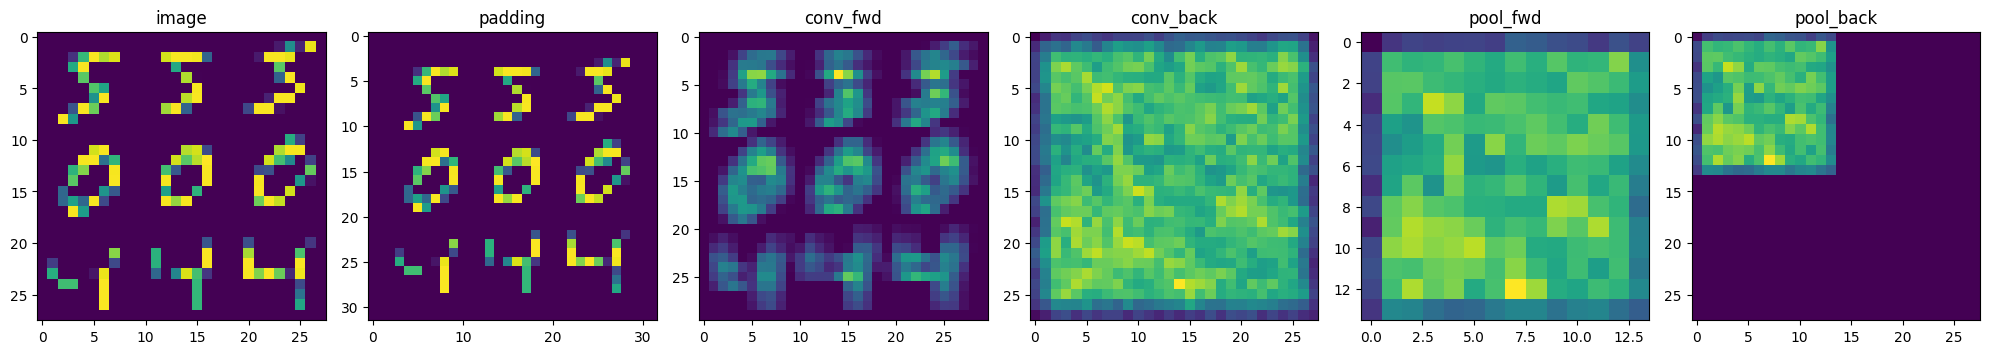

In [98]:
kernel = np.random.rand(3, 3, 3, 3)  # Convolution kernel with size 3x3 and 3 input/output channels
image_padded = zero_pad(image, 2)
print(image_padded.shape)
# Convolution forward pass
conv_result = convolution_forward(image_padded, kernel)
print(conv_result.shape)
# # Convolution backward pass
doutput = np.random.rand(*conv_result.shape)  # Gradient of the loss with respect to the output of the convolution layer
dimage, dkernel = convolution_backward(doutput, image, kernel)

# Max pooling forward pass
pool_result, mask = pool_forward(dimage, {"stride" : 2, "f": 1})


# Max pooling backward pass
pool_result_back = pool_backward(pool_result, mask)

fig, axarr = plt.subplots(1, 6, figsize=(20, 25))
axarr[0].set_title('image')
axarr[0].imshow(image[0,:,:,0])
axarr[1].set_title('padding')
axarr[1].imshow(image_padded[0,:,:,0])
axarr[2].set_title('conv_fwd')
axarr[2].imshow(conv_result[0,:,:,0])
axarr[3].set_title('conv_back')
axarr[3].imshow(dimage[0,:,:,0])
axarr[4].set_title('pool_fwd')
axarr[4].imshow(pool_result[0,:,:,0])
axarr[5].set_title('pool_back')
axarr[5].imshow(pool_result_back[0,:,:,0])
plt.tight_layout()
plt.show()